# EDA


- The os module has a perfect method to list files in a directory.
- Pandas json normalize could work here but is not necessary to convert the JSON data to a dataframe.
- You may need a nested for-loop to access each sale!
- We've put a lot of time into creating the structure of this repository, and it's a good example for future projects.  In the file functions_variables.py, there is an example function that you can import and use.  If you have any variables, functions or classes that you want to make, they can be put in the functions_variables.py file and imported into a notebook.  Note that only .py files can be imported into a notebook. If you want to import everything from a .py file, you can use the following:
```python
from functions_variables import *
```
If you just import functions_variables, then each object from the file will need to be prepended with "functions_variables"\
Using this .py file will keep your notebooks very organized and make it easier to reuse code between notebooks.

In [52]:
# (this is not an exhaustive list of libraries)
import pandas as pd
import numpy as np
import os
import json
from pprint import pprint
from functions_variables import encode_tags
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder

## Data Importing

In [53]:
# load one file first to see what type of data you're dealing with and what attributes it has

# Define the data directory and file path
current_dir = os.getcwd()
main_dir = os.path.abspath(os.path.join(current_dir, '..'))
data_dir = os.path.join(main_dir, 'data')
sample_file = os.path.join(data_dir, "AK_Juneau_0.json")

# Load JSON data
with open(sample_file, "r") as f:
    sample_data = json.load(f)

# Convert JSON to a DataFrame
json_structure = pd.DataFrame(sample_data)

# Creating a file for csv data:
csv_dir = os.path.join(main_dir, 'csv_data')
os.makedirs(csv_dir, exist_ok=True)

# Saving json_structure df to csv: 
json_structure.to_csv(os.path.join(csv_dir, 'json_structure.csv'), index=False)
print("CSV file created successfully!")

CSV file created successfully!


In [54]:
# Print a preview of the data
print(json.dumps(sample_data, indent=4))

{
    "status": 200,
    "data": {
        "total": 8,
        "count": 8,
        "results": [
            {
                "primary_photo": {
                    "href": "https://ap.rdcpix.com/07097d34c98a59ebb799688986ef271dl-m2867511255s-w1024_h768.jpg"
                },
                "last_update_date": "2023-09-19T20:52:50Z",
                "source": {
                    "plan_id": null,
                    "agents": [
                        {
                            "office_name": "EXP Realty LLC - Southeast Alaska"
                        },
                        {
                            "office_name": "Non-Member Office"
                        }
                    ],
                    "spec_id": null,
                    "type": "mls"
                },
                "tags": [
                    "carport",
                    "community_outdoor_space",
                    "cul_de_sac",
                    "family_room",
                    "hardwood_fl

In [55]:
# loop over all files and put them into a dataframe

# Initialize a list to store extracted sale records
data_list = []

# Loop through each JSON file
for file in os.listdir(data_dir):
    if not file.endswith('.json'):
        continue
        
    file_path = os.path.join(data_dir, file)  # Construct full file path
    
    with open(file_path, "r") as f:
        raw_data = json.load(f)  # Load JSON data
        
        # Extract property listings (assuming structure is in "data" -> "results")
        listings = raw_data.get("data", {}).get("results", [])

        if not isinstance(listings, list):  # Check if "results" is not a list
            print(f"Skipping malformed file: {file}")
            continue  # Skip files without proper listings

        # Process each listing
        for listing in listings:
            sale_record = {
                "property_id": listing.get("property_id", "Unknown"),
                "permalink": listing.get("permalink", "Unknown"),
                "status": listing.get("status", "Unknown"),
                "year_built": listing.get("description", {}).get("year_built", None),
                "garage": listing.get("description", {}).get("garage", None),
                "stories": listing.get("description", {}).get("stories", None),
                "beds": listing.get("description", {}).get("beds", None),
                "baths_1qtr": listing.get("description", {}).get("baths_1qtr", None),
                "baths_3qtr": listing.get("description", {}).get("baths_3qtr", None),
                "baths_half": listing.get("description", {}).get("baths_half", None),
                "baths_full": listing.get("description", {}).get("baths_full", None),
                "baths": listing.get("description", {}).get("baths", "Unknown"),
                "type": listing.get("description", {}).get("type", "Unknown"),
                "sub_type": listing.get("description", {}).get("sub_type", "Unknown"),
                "lot_sqft": listing.get("description", {}).get("lot_sqft", None),
                "sqft": listing.get("description", {}).get("sqft", None),
                "sold_price": listing.get("description", {}).get("sold_price", None),
                "sold_date": pd.to_datetime(listing.get("description", {}).get("sold_date", "Unknown")),
                "list_price": listing.get("list_price", None),
                "last_update_date": pd.to_datetime(listing.get("last_update_date"), errors='coerce'),
                "city": listing.get("location", {}).get("address", {}).get("city", "Unknown"),
                "state": listing.get("location", {}).get("address", {}).get("state", "Unknown"),
                "postal_code": listing.get("location", {}).get("address", {}).get("postal_code", "Unknown"),
                "street_view_url": listing.get("location", {}).get("street_view_url", "Unknown"),
                "tags": listing.get("tags", [])  
            }
            data_list.append(sale_record)

# Convert extracted data into a DataFrame
listings_df = pd.DataFrame(data_list)

# Save to CSV for easier analysis
listings_df.to_csv(os.path.join(csv_dir, "raw_real_estate_listings.csv"), index=False)
print("CSV file created successfully!")

Skipping malformed file: ME_Augusta_4.json
Skipping malformed file: MS_Jackson_0.json
Skipping malformed file: MS_Jackson_1.json
Skipping malformed file: WY_Cheyenne_4.json
Skipping malformed file: VT_Montpelier_4.json
Skipping malformed file: WY_Cheyenne_3.json
Skipping malformed file: SD_Pierre_0.json
Skipping malformed file: ME_Augusta_2.json
Skipping malformed file: VT_Montpelier_3.json
Skipping malformed file: ME_Augusta_3.json
Skipping malformed file: VT_Montpelier_2.json
Skipping malformed file: SD_Pierre_1.json
Skipping malformed file: WY_Cheyenne_2.json
Skipping malformed file: SD_Pierre_2.json
Skipping malformed file: MS_Jackson_4.json
Skipping malformed file: NH_Concord_4.json
Skipping malformed file: WY_Cheyenne_1.json
Skipping malformed file: VT_Montpelier_1.json
Skipping malformed file: ME_Augusta_0.json
Skipping malformed file: ND_Bismarck_2.json
Skipping malformed file: HI_Honolulu_3.json
Skipping malformed file: ND_Bismarck_3.json
Skipping malformed file: VT_Montpelier

## Data Cleaning and Wrangling

At this point, ensure that you have all sales in a dataframe.
- Take a quick look at your data (i.e. `.info()`, `.describe()`) - what do you see?
- Is each cell one value, or do some cells have lists?
- What are the data types of each column?
- Some sales may not actually include the sale price (target).  These rows should be dropped.
- There are a lot of NA/None values.  Should these be dropped or replaced with something?
    - You can drop rows or use various methods to fills NA's - use your best judgement for each column 
    - i.e. for some columns (like Garage), NA probably just means no Garage, so 0
- Drop columns that aren't needed
    - Don't keep the list price because it will be too close to the sale price. Assume we want to predict the price of houses not yet listed

In [56]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8159 entries, 0 to 8158
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   property_id       8159 non-null   object        
 1   permalink         8159 non-null   object        
 2   status            8159 non-null   object        
 3   year_built        7316 non-null   float64       
 4   garage            4448 non-null   float64       
 5   stories           6260 non-null   float64       
 6   beds              7504 non-null   float64       
 7   baths_1qtr        0 non-null      object        
 8   baths_3qtr        566 non-null    float64       
 9   baths_half        2281 non-null   float64       
 10  baths_full        7311 non-null   float64       
 11  baths             7980 non-null   float64       
 12  type              8125 non-null   object        
 13  sub_type          1427 non-null   object        
 14  lot_sqft          6991 n

At first glance, `baths_1qtr` has all null values and should be dropped.

In [57]:
listings_df.describe()

,year_built,garage,stories,beds,baths_3qtr,baths_half,baths_full,baths,lot_sqft,sqft,sold_price,sold_date,list_price
count,7316.000000,4448.000000,6260.000000,7504.000000,566.000000,2281.000000,7311.000000,7980.000000,6.991000e+03,7323.000000,6.716000e+03,8159,7.721000e+03
mean,1968.916074,1.926709,1.567732,3.208289,1.247350,1.105655,1.887430,2.131203,2.510949e+05,1933.848559,4.126050e+05,2023-12-16 16:32:35.533766144,4.341582e+05
min,1828.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,120.000000,3.080000e+02,2023-07-21 00:00:00,1.000000e+00
25%,1950.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.953000e+03,1258.000000,1.910000e+05,2023-12-18 00:00:00,2.090000e+05
50%,1975.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,2.000000,7.841000e+03,1635.000000,3.140000e+05,2024-01-04 00:00:00,3.250000e+05
75%,1997.000000,2.000000,2.000000,4.000000,1.000000,1.000000,2.000000,3.000000,1.263200e+04,2264.000000,4.700000e+05,2024-01-10 00:00:00,4.999000e+05
max,2024.000000,11.000000,10.000000,12.000000,3.000000,5.000000,8.000000,9.000000,1.676624e+08,32106.000000,2.706500e+07,2024-01-17 00:00:00,1.250000e+07
std,35.096914,0.878766,0.730969,1.282732,0.463482,0.413340,0.862214,1.175940,5.823820e+06,1339.039206,6.994308e+05,NaN,5.514925e+05


In [58]:
# Loading and inspecting the data
listings_df

,property_id,permalink,status,year_built,garage,stories,beds,baths_1qtr,baths_3qtr,baths_half,...,sqft,sold_price,sold_date,list_price,last_update_date,city,state,postal_code,street_view_url,tags
0,3300959879,1869-Pebble-Ct_Harrisburg_PA_17110_M33009-59879,sold,2001.0,2.0,1.0,3.0,None,NaN,NaN,...,1539.0,345000.0,2024-01-16,334900.0,2024-01-17 00:01:55+00:00,Harrisburg,Pennsylvania,17110,https://maps.googleapis.com/maps/api/streetvie...,"[central_air, dishwasher, fireplace, forced_ai..."
1,3149247078,3100-N-3rd-St_Harrisburg_PA_17110_M31492-47078,sold,1900.0,3.0,NaN,3.0,None,NaN,NaN,...,2429.0,196000.0,2024-01-16,185000.0,2024-01-16 16:49:36+00:00,Harrisburg,Pennsylvania,17110,https://maps.googleapis.com/maps/api/streetvie...,"[disability_features, basement, garage_1_or_mo..."
2,4686076173,7551-Davids-Rd_Harrisburg_PA_17111_M46860-76173,sold,1971.0,NaN,1.0,3.0,None,NaN,NaN,...,1120.0,205000.0,2024-01-12,197000.0,2024-01-13 00:03:39+00:00,Harrisburg,Pennsylvania,17111,https://maps.googleapis.com/maps/api/streetvie...,"[carport, central_air, dishwasher, fireplace, ..."
3,4085014275,2722-Bur-Ct_Harrisburg_PA_17112_M40850-14275,sold,2013.0,1.0,2.0,3.0,None,NaN,1.0,...,2400.0,295000.0,2024-01-12,295000.0,2024-01-16 07:48:30+00:00,Harrisburg,Pennsylvania,17112,https://maps.googleapis.com/maps/api/streetvie...,"[central_air, dining_room, disability_features..."
4,3743385520,404-Crescent-St_Harrisburg_PA_17104_M37433-85520,sold,1900.0,NaN,NaN,3.0,None,NaN,NaN,...,1478.0,106000.0,2024-01-12,105000.0,2024-01-13 00:01:45+00:00,Harrisburg,Pennsylvania,17104,https://maps.googleapis.com/maps/api/streetvie...,"[dining_room, hardwood_floors, basement]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,9013856578,10715-Mangrove-Dr_Indianapolis_IN_46239_M90138...,sold,NaN,NaN,NaN,NaN,None,NaN,NaN,...,NaN,349990.0,2023-08-23,NaN,None,Indianapolis,Indiana,46239,https://maps.googleapis.com/maps/api/streetvie...,None
8155,4849020881,8903-E-15th-St_Indianapolis_IN_46219_M48490-20881,sold,1960.0,2.0,1.0,4.0,None,NaN,NaN,...,1852.0,140000.0,2023-08-22,144900.0,2023-08-22 17:54:39+00:00,Indianapolis,Indiana,46219,https://maps.googleapis.com/maps/api/streetvie...,"[hardwood_floors, single_story, garage_1_or_mo..."
8156,4445938965,6054-Southbay-Dr_Indianapolis_IN_46250_M44459-...,sold,1985.0,1.0,NaN,3.0,None,NaN,2.0,...,1824.0,210000.0,2023-08-18,195900.0,2023-08-18 19:18:03+00:00,Indianapolis,Indiana,46250,https://maps.googleapis.com/maps/api/streetvie...,"[central_air, city_view, dining_room, family_r..."
8157,3391199956,6412-Cotton-Bay-Dr-N_Indianapolis_IN_46254_M33...,sold,1989.0,2.0,2.0,2.0,None,NaN,NaN,...,1504.0,163000.0,2023-08-17,169900.0,2023-08-17 19:23:27+00:00,Indianapolis,Indiana,46254,https://maps.googleapis.com/maps/api/streetvie...,"[city_view, community_spa_or_hot_tub, communit..."


In [59]:
# Dropping entrites with duplicate 'property_id'

listings_df = listings_df.drop_duplicates(subset='property_id')

In [60]:
# Modifying datatypes

# float to int
listings_df.loc[:, 'year_built'] = listings_df['year_built'].astype('Int64') 
listings_df.loc[:, 'garage'] = listings_df['garage'].astype('Int64')
listings_df.loc[:, 'stories'] = listings_df['stories'].astype('Int64')
listings_df.loc[:, 'beds'] = listings_df['beds'].astype('Int64')
listings_df.loc[:, 'baths'] = listings_df['baths'].astype('Int64')

# Remove time from last_update_date and convert to datetime64
listings_df.loc[:, 'last_update_date'] = pd.to_datetime(listings_df['last_update_date'].astype('str').str[:10], errors='coerce')

/var/folders/vh/hr9w_0vd1xv4xfslxfhrwmxh0000gn/T/ipykernel_18523/3745123928.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[2001, 1900, 1971, 2013, 1900, 1900, 1900, 1940, 1957, <NA>,
 ...
 1974, 1960, <NA>, <NA>, 1991, 1978, 2002, 1948, 1886, 1993]
Length: 1795, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  listings_df.loc[:, 'year_built'] = listings_df['year_built'].astype('Int64')
/var/folders/vh/hr9w_0vd1xv4xfslxfhrwmxh0000gn/T/ipykernel_18523/3745123928.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<IntegerArray>
[   2,    3, <NA>,    1, <NA>, <NA>, <NA>, <NA>, <NA>, <NA>,
 ...
    1,    2, <NA>, <NA>,    2,    5,    2, <NA>, <NA>,    2]
Length: 1795, dtype: Int64' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  l

In [61]:
# Addressing Null values 

pd.DataFrame(listings_df.isnull().sum() * 100 / len(listings_df)).reset_index().sort_values(0, ascending=False).rename(columns={'index': 'column_name',
                                                                                                              0: 'percent_missing'})

,column_name,percent_missing
7,baths_1qtr,100.000000
8,baths_3qtr,93.036212
13,sub_type,82.618384
9,baths_half,72.089136
4,garage,45.515320
5,stories,23.621170
16,sold_price,17.827298
14,lot_sqft,14.206128
10,baths_full,10.417827
15,sqft,10.362117


In [62]:
# Dropping the 4 columns wehere over 50% of the data is null (baths_1qtr)
listings_df = listings_df.drop(columns=['baths_1qtr','baths_3qtr', 'sub_type', 'baths_half'])

# Dropping the redundant 'baths_full' column in favor of the 'baths' column
listings_df = listings_df.drop(columns='baths_full')

# Dropping the 'list_price' column in favor of 'sold_price' to predict the prices of houses not listed
listings_df = listings_df.drop(columns='list_price')

# Dropping the rows that have a null sale price (target)
listings_df = listings_df[~listings_df['sold_price'].isnull()]

In [63]:
# To suppress the warning that results from filling last_update_date 
pd.set_option('future.no_silent_downcasting', True)

In [64]:
# Null value replacement

# if none then 0: 
listings_df['garage'] = listings_df['garage'].fillna(value=0) 
listings_df['lot_sqft'] = listings_df['lot_sqft'].fillna(value=0)
listings_df['sqft'] = listings_df['sqft'].fillna(value=0)
listings_df['beds'] = listings_df['beds'].fillna(value=0)
listings_df['baths'] = listings_df['baths'].fillna(value=0)
listings_df['tags'] = listings_df['tags'].fillna(value='[]')

listings_df['last_update_date'] = listings_df['last_update_date'].fillna(value=listings_df['sold_date']) # Assuming the listing was last updated on the day it sold 
print('null type count:', listings_df[listings_df['type'].isnull() ==True].shape[0])
listings_df['type'] = listings_df['type'].fillna(value='single_family') # Only a few entries, validated type manually through zillow search 

print('null city count:', listings_df[listings_df['city'].isnull() ==True].shape[0])
listings_df['city'] = listings_df['city'].fillna(value='Columbus') # Only one entry, validated city manually through search 

listings_df['stories'] = listings_df['stories'].fillna(value=0) # Manually validated some addresses with stories null, appears to be warehouses, fields, etc

null type count: 4
null city count: 1


In [65]:
# Null year_built:

null_years_built = listings_df[listings_df['year_built'].isnull() == True]
null_years_built

,property_id,permalink,status,year_built,garage,stories,beds,baths,type,lot_sqft,sqft,sold_price,sold_date,last_update_date,city,state,postal_code,street_view_url,tags
9,3092875659,Walnut-Ave-Lot-11_Harrisburg_PA_17112_M30928-7...,sold,<NA>,0,0,0,0,land,15682.0,0.0,28000.0,2024-01-12,2024-01-13 00:00:00,Harrisburg,Pennsylvania,17112,https://maps.googleapis.com/maps/api/streetvie...,[]
107,9241050124,2122B-12th-Ave-N_Nashville_TN_37208_M92410-50124,sold,<NA>,0,0,0,0,single_family,0.0,0.0,710000.0,2023-09-01,2023-11-20 00:00:00,Nashville,Tennessee,37208,https://maps.googleapis.com/maps/api/streetvie...,[]
110,9036979390,303-31st-Ave-N-Apt-206_Nashville_TN_37203_M903...,sold,<NA>,0,0,0,0,condo,0.0,0.0,534900.0,2023-07-27,2023-10-23 00:00:00,Nashville,Tennessee,37203,https://maps.googleapis.com/maps/api/streetvie...,[]
117,7350121055,6000-Marrowbone-Lake-Rd_Joelton_TN_37080_M7350...,sold,<NA>,0,1,0,0,mobile,86249.0,0.0,170000.0,2023-07-21,2023-10-20 00:00:00,Joelton,Tennessee,37080,https://maps.googleapis.com/maps/api/streetvie...,[]
122,9753649228,1907-Mackiebeth-Ct_Annapolis_MD_21401_M97536-4...,sold,<NA>,0,0,0,0,land,64226.0,0.0,224825.0,2024-01-12,2024-01-14 00:00:00,Annapolis,Maryland,21401,https://maps.googleapis.com/maps/api/streetvie...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,9724131788,Division-St_Boone_IA_50036_M97241-31788,sold,<NA>,0,0,0,0,land,2381425.0,0.0,820000.0,2024-01-04,2024-01-04 00:00:00,Boone,Iowa,50036,https://maps.googleapis.com/maps/api/streetvie...,[]
5939,9835758220,140th-St_Boone_IA_50036_M98357-58220,sold,<NA>,0,0,0,0,land,6969600.0,0.0,2016000.0,2024-01-04,2024-01-09 00:00:00,Boone,Iowa,50036,https://maps.googleapis.com/maps/api/streetvie...,"[rental_property, big_lot, farm]"
6149,9637850403,2909-Katmai-Dr-A_Columbus_OH_43228_M96378-50403,sold,<NA>,0,0,0,0,condo,0.0,0.0,792600.0,2023-09-08,2023-12-19 00:00:00,Columbus,Ohio,43228,https://maps.googleapis.com/maps/api/streetvie...,[]
6192,3003028850,32-Grosvenor-Ave_Providence_RI_02908_M30030-28850,sold,<NA>,0,0,0,0,land,3049.0,0.0,128500.0,2024-01-16,2024-01-16 00:00:00,Providence,Rhode Island,02908,https://maps.googleapis.com/maps/api/streetvie...,[]


In [66]:
null_years_built.groupby('type').count()

,property_id,permalink,status,year_built,garage,stories,beds,baths,lot_sqft,sqft,sold_price,sold_date,last_update_date,city,state,postal_code,street_view_url,tags
type,,,,,,,,,,,,,,,,,,
condo,9,9,9,0,9,9,9,9,9,9,9,9,9,9,9,9,9,9
land,71,71,71,0,71,71,71,71,71,71,71,71,71,71,71,71,71,71
mobile,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
multi_family,3,3,3,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3
other,2,2,2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2
single_family,59,59,59,0,59,59,59,59,59,59,59,59,59,59,59,59,59,59
townhomes,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [67]:
listings_df.groupby(by=['type', 'city'])['year_built'].min()['land']

city
Annapolis           <NA>
Atlanta             <NA>
Boone               <NA>
Canal Winchester    <NA>
Carson City         <NA>
Charleston          <NA>
Columbus            <NA>
Denver              <NA>
Dublin              <NA>
Edmond              <NA>
Garnett             <NA>
Harrisburg          <NA>
Hartford            <NA>
Henrico             <NA>
Lincoln             <NA>
Little Rock         <NA>
Montgomery          <NA>
Olympia             <NA>
Phoenix             1956
Providence          <NA>
Saint Paul          <NA>
Salem               <NA>
Spencer             <NA>
Springfield         <NA>
Tallahassee         <NA>
Trenton             <NA>
Westerville         <NA>
Name: year_built, dtype: Int64

In [68]:
listings_df.groupby(by=['type', 'city'])['year_built'].min()['condo']

city
Columbus       <NA>
Nashville      1985
Springfield    <NA>
Name: year_built, dtype: Int64

The majority of records that have null `year_built` are of `land` or `single_family` type. For those of `single_family` type, values will be grouped by type and city, and the most frequently occured year will be the replacement. Only one record of 'year_built' exists for the listings of `land` type, the year 1956 in Phoenix, Arizona. This value is used to impute records with null 'year_built' that is of `land` type. It is important to note that this imputation will reduce the variability of the data. A similar issue exists for those of the `condo` type, with the only record of the year 1985 in Nashville. The same imputation method will be used. The two entries that are of type `other` are the only entries in the dataframe of that type, and upon manual inspection the listings are for the lot or incomplete so they will be dropped. After the conditions are applied, there are only 3 records left, whose `year_built` information cannot be found online. To maintain more data integretity, these records will be dropped instead of trying to find a statristic to generalize. 

In [69]:
listings_df[listings_df['year_built'].isnull() == True]

,property_id,permalink,status,year_built,garage,stories,beds,baths,type,lot_sqft,sqft,sold_price,sold_date,last_update_date,city,state,postal_code,street_view_url,tags
9,3092875659,Walnut-Ave-Lot-11_Harrisburg_PA_17112_M30928-7...,sold,<NA>,0,0,0,0,land,15682.0,0.0,28000.0,2024-01-12,2024-01-13 00:00:00,Harrisburg,Pennsylvania,17112,https://maps.googleapis.com/maps/api/streetvie...,[]
107,9241050124,2122B-12th-Ave-N_Nashville_TN_37208_M92410-50124,sold,<NA>,0,0,0,0,single_family,0.0,0.0,710000.0,2023-09-01,2023-11-20 00:00:00,Nashville,Tennessee,37208,https://maps.googleapis.com/maps/api/streetvie...,[]
110,9036979390,303-31st-Ave-N-Apt-206_Nashville_TN_37203_M903...,sold,<NA>,0,0,0,0,condo,0.0,0.0,534900.0,2023-07-27,2023-10-23 00:00:00,Nashville,Tennessee,37203,https://maps.googleapis.com/maps/api/streetvie...,[]
117,7350121055,6000-Marrowbone-Lake-Rd_Joelton_TN_37080_M7350...,sold,<NA>,0,1,0,0,mobile,86249.0,0.0,170000.0,2023-07-21,2023-10-20 00:00:00,Joelton,Tennessee,37080,https://maps.googleapis.com/maps/api/streetvie...,[]
122,9753649228,1907-Mackiebeth-Ct_Annapolis_MD_21401_M97536-4...,sold,<NA>,0,0,0,0,land,64226.0,0.0,224825.0,2024-01-12,2024-01-14 00:00:00,Annapolis,Maryland,21401,https://maps.googleapis.com/maps/api/streetvie...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,9724131788,Division-St_Boone_IA_50036_M97241-31788,sold,<NA>,0,0,0,0,land,2381425.0,0.0,820000.0,2024-01-04,2024-01-04 00:00:00,Boone,Iowa,50036,https://maps.googleapis.com/maps/api/streetvie...,[]
5939,9835758220,140th-St_Boone_IA_50036_M98357-58220,sold,<NA>,0,0,0,0,land,6969600.0,0.0,2016000.0,2024-01-04,2024-01-09 00:00:00,Boone,Iowa,50036,https://maps.googleapis.com/maps/api/streetvie...,"[rental_property, big_lot, farm]"
6149,9637850403,2909-Katmai-Dr-A_Columbus_OH_43228_M96378-50403,sold,<NA>,0,0,0,0,condo,0.0,0.0,792600.0,2023-09-08,2023-12-19 00:00:00,Columbus,Ohio,43228,https://maps.googleapis.com/maps/api/streetvie...,[]
6192,3003028850,32-Grosvenor-Ave_Providence_RI_02908_M30030-28850,sold,<NA>,0,0,0,0,land,3049.0,0.0,128500.0,2024-01-16,2024-01-16 00:00:00,Providence,Rhode Island,02908,https://maps.googleapis.com/maps/api/streetvie...,[]


In [70]:
# Replace null values for 'year_built'

# Define conditions 
condition_sf = (listings_df['type'] == 'single_family') & (listings_df['year_built'].isna())
condition_land = (listings_df['type'] == 'land') & (listings_df['year_built'].isna())
condition_condo = (listings_df['type'] == 'condo') & (listings_df['year_built'].isna())
condition_mobile = (listings_df['type'] == 'mobile') & (listings_df['year_built'].isna())
# Manual search conditions
condition_ms1 = (listings_df['property_id'] == '5328654220') & (listings_df['year_built'].isna())   
condition_ms2 = (listings_df['property_id'] == '9414271198') & (listings_df['year_built'].isna())

condition_ms3 = (listings_df['property_id'] == '9988039199') & (listings_df['year_built'].isna())
condition_ms4 = (listings_df['property_id'] == '3377433199') & (listings_df['year_built'].isna())

# Group by type and city, then get mode of rows of single family type
sf_modes = (listings_df[listings_df['type'] == 'single_family'].groupby(['type', 'city'])['year_built'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA))

# Define a function to get the mode from the groupby
def get_mode(row):
    try:
        return sf_modes.loc[(row['type'], row['city'])]
    except KeyError:
        return row['year_built']  # fallback if no mode available

# Apply the function to the single_family condition
listings_df.loc[condition_sf, 'year_built'] = listings_df[condition_sf].apply(get_mode, axis=1)
print('null type count after single_family modes:', listings_df[listings_df['year_built'].isnull() ==True].shape[0])

# Manually validating and imputation everything else
listings_df.loc[condition_land, 'year_built'] = 1956
listings_df.loc[condition_condo, 'year_built'] = 1985
listings_df = listings_df[listings_df['type'] != 'other']
listings_df.loc[condition_mobile, 'year_built'] = 1988

# Values obtained through manual search
listings_df.loc[condition_ms1, 'year_built'] = 1876
listings_df.loc[condition_ms2, 'year_built'] = 2023
listings_df.loc[condition_ms3, 'year_built'] = 1983
listings_df.loc[condition_ms4, 'year_built'] = 1981
print('null type count after manual conditions:', listings_df[listings_df['year_built'].isnull() ==True].shape[0])

# Dropping remaining rows
listings_df = listings_df[listings_df['year_built'].isnull() == False]

null type count after single_family modes: 90
null type count after manual conditions: 3


In [71]:
# Drop remaining redundant columns 
listings_df = listings_df.drop(columns=['permalink', 'postal_code', 'street_view_url', 'sold_date', 'last_update_date'])

# Checking that all listings are confirmed to be sold before dropping the status column
print('Listing statuses:')
print(listings_df['status'].unique())
listings_df = listings_df.drop(columns='status')

Listing statuses:
['sold']


In [72]:
# Validate cleaned dataframe and save to csv
display(listings_df.head())
display(listings_df.info())

listings_df.to_csv(os.path.join(csv_dir, "cleaned_real_estate_listings.csv"), index=False)
print("CSV file created successfully!")

,property_id,year_built,garage,stories,beds,baths,type,lot_sqft,sqft,sold_price,city,state,tags
0,3300959879,2001,2,1,3,2,single_family,22651.0,1539.0,345000.0,Harrisburg,Pennsylvania,"[central_air, dishwasher, fireplace, forced_ai..."
1,3149247078,1900,3,0,3,0,multi_family,2614.0,2429.0,196000.0,Harrisburg,Pennsylvania,"[disability_features, basement, garage_1_or_mo..."
2,4686076173,1971,0,1,3,2,single_family,13504.0,1120.0,205000.0,Harrisburg,Pennsylvania,"[carport, central_air, dishwasher, fireplace, ..."
3,4085014275,2013,1,2,3,3,townhomes,2688.0,2400.0,295000.0,Harrisburg,Pennsylvania,"[central_air, dining_room, disability_features..."
4,3743385520,1900,0,0,3,0,multi_family,871.0,1478.0,106000.0,Harrisburg,Pennsylvania,"[dining_room, hardwood_floors, basement]"


<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 0 to 7949
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   property_id  1470 non-null   object 
 1   year_built   1470 non-null   Int64  
 2   garage       1470 non-null   Int64  
 3   stories      1470 non-null   Int64  
 4   beds         1470 non-null   Int64  
 5   baths        1470 non-null   Int64  
 6   type         1470 non-null   object 
 7   lot_sqft     1470 non-null   float64
 8   sqft         1470 non-null   float64
 9   sold_price   1470 non-null   float64
 10  city         1470 non-null   object 
 11  state        1470 non-null   object 
 12  tags         1470 non-null   object 
dtypes: Int64(5), float64(3), object(5)
memory usage: 168.0+ KB


None

CSV file created successfully!


In [73]:
print(f"Number of columns: {listings_df.shape[1]}")

Number of columns: 13


In [74]:
# Feature engineering

listings_df['total_sqft'] = listings_df['lot_sqft'] + listings_df['sqft']
listings_df['building_ratio'] = listings_df['sqft'] / listings_df['lot_sqft'] # higher ratio = more building area(urban), 0 = all lot no building
listings_df['building_ratio'] = listings_df['building_ratio'].replace([np.inf, -np.inf], np.nan) # fixing cases where ratio is inf (0 sqft and positive lot sqft) 
listings_df['building_ratio'] = listings_df['building_ratio'].fillna(value=listings_df['building_ratio'].mean()) # filling nulls with global building ratio

### Dealing with Tags

Consider the fact that with tags, there are a lot of categorical variables.
- How many columns would we have if we OHE tags, city and state?
- Perhaps we can get rid of tags that have a low frequency.

In [75]:
# OHE categorical variables/ tags here
# tags will have to be done manually

In [76]:
# Estimate the Number of Columns Created by OHE
print(f"Unique tags: {listings_df['tags'].explode().nunique()}")
print(f"Unique cities: {listings_df['city'].nunique()}")
print(f"Unique states: {listings_df['state'].nunique()}")

Unique tags: 153
Unique cities: 83
Unique states: 35


In [77]:
# Encode tags
listings_df = encode_tags(listings_df, min_occurrences=100)

# Dropping original tag column 
listings_df = listings_df.drop(columns='tags')

# Check updated column count
print(f"Updated column count: {len(listings_df.columns)}")

Updated column count: 50


### Dealing with Cities

- Sales will vary drastically between cities and states.  Is there a way to keep information about which city it is without OHE?
- Could we label encode or ordinal encode?  Yes, but this may have undesirable effects, giving nominal data ordinal values.
- What we can do is use our training data to encode the mean sale price by city as a feature (a.k.a. Target Encoding)
    - We can do this as long as we ONLY use the training data - we're using the available data to give us a 'starting guess' of the price for each city, without needing to encode city explicitly
- If you replace cities or states with numerical values (like the mean price), make sure that the data is split so that we don't leak data into the training selection. This is a great time to train test split. Compute on the training data, and join these values to the test data
- Note that you *may* have cities in the test set that are not in the training set. You don't want these to be NA, so maybe you can fill them with the overall mean

In [78]:
# perform train test split here
from category_encoders import TargetEncoder

# Using k-fold CV with shuffle for a dataset this size 
X = listings_df.drop(columns='sold_price')
y = listings_df['sold_price']

kf = KFold(n_splits=5, shuffle=True, random_state=13)

# Isolating train/test dataframes from k-fold split
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Initiating target encoder and only transforming the training set     
    encoder = TargetEncoder(cols=['city', 'state'], smoothing=3)
    encoded_data = encoder.fit_transform(X_train[['city', 'state']], y_train)

    # Inserting encoded data into main dataframe
    listings_df['encoded_city'] = round((encoded_data['city']), 2) 
    listings_df['encoded_state'] = round((encoded_data['state']), 2) 

In [79]:
# Viewing encoded city and state columns side by side to validate

city_encodings = listings_df[['city', 'encoded_city']].dropna(subset=['encoded_city']).drop_duplicates('city').sort_values(by='encoded_city', ascending=False)
state_encodings = listings_df[['state', 'encoded_state']].dropna(subset=['encoded_state']).drop_duplicates('state').sort_values(by='encoded_state', ascending=False)

display(city_encodings.head(10))
display(state_encodings.head(10))

,city,encoded_city
583,Boston,1386069.41
1486,Springfield,1072822.82
121,Annapolis,771001.06
289,Denver,663011.68
1056,Providence,639111.43
458,Atlanta,564139.58
886,Raleigh,561299.67
206,Phoenix,551084.35
2612,Carson City,521114.58
751,Sacramento,513244.12


,state,encoded_state
583,Massachusetts,1386069.41
1486,Illinois,1072822.82
121,Maryland,771001.06
289,Colorado,663011.68
1056,Rhode Island,631047.96
457,Georgia,562340.61
886,North Carolina,561299.67
205,Arizona,530227.11
2612,Nevada,521114.58
106,Tennessee,496829.18


In [80]:
# Use encoded values to fill in test set 
city_mappings = city_encodings.set_index('city')['encoded_city']
state_mappings = state_encodings.set_index('state')['encoded_state']

listings_df['encoded_city'] = listings_df['encoded_city'].fillna(listings_df['city'].map(city_mappings))
listings_df['encoded_state'] = listings_df['encoded_state'].fillna(listings_df['state'].map(state_mappings))

In [81]:
# Check for nulls, replace with global city/state means if exist 

overall_mean_price = listings_df["sold_price"].mean()
listings_df["encoded_city"] = listings_df["encoded_city"].fillna(overall_mean_price)
listings_df["encoded_state"] = listings_df["encoded_state"].fillna(overall_mean_price)
listings_df["encoded_city"] = listings_df["encoded_city"].astype('float')
listings_df["encoded_state"] = listings_df["encoded_state"].astype('float')

listings_df[['encoded_city', 'encoded_state']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 0 to 7949
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   encoded_city   1470 non-null   float64
 1   encoded_state  1470 non-null   float64
dtypes: float64(2)
memory usage: 34.5 KB


In [82]:
# Encoding remaining categorical columns 

# Conditions for encoding type
type1 = listings_df['type'] == 'mobile'
type2 = listings_df['type'] == 'apartment' 
type3 = listings_df['type'] == 'condo'
type4 = listings_df['type'] == 'condos'
type5 = listings_df['type'] == 'condo_townhome_rowhome_coop'
type6 = listings_df['type'] == 'townhomes'
type7 = listings_df['type'] == 'single_family'
type8 = listings_df['type'] == 'duplex_triplex'
type9 = listings_df['type'] == 'multi_family'
type10 = listings_df['type'] == 'land'

listings_df.loc[type1, 'type'] = 1.0
listings_df.loc[type2, 'type'] = 2
listings_df.loc[type3, 'type'] = 3
listings_df.loc[type4, 'type'] = 4
listings_df.loc[type5, 'type'] = 5
listings_df.loc[type6, 'type'] = 6
listings_df.loc[type7, 'type'] = 7
listings_df.loc[type8, 'type'] = 8
listings_df.loc[type9, 'type'] = 9
listings_df.loc[type10, 'type'] = 10
listings_df['type'] = listings_df['type'].astype('Int64')      

In [83]:
listings_df.select_dtypes(include=object) # drop property id and last update date? 

,property_id,city,state
0,3300959879,Harrisburg,Pennsylvania
1,3149247078,Harrisburg,Pennsylvania
2,4686076173,Harrisburg,Pennsylvania
3,4085014275,Harrisburg,Pennsylvania
4,3743385520,Harrisburg,Pennsylvania
...,...,...,...
7485,7324213430,Edmond,Oklahoma
7780,1003442504,Carson City,Nevada
7906,5266199345,Richmond,Virginia
7948,5236362165,Trenton,New Jersey


Many listings of the 'mobile' type have 0 sqft in total after feature engineering

In [84]:
# Save encoded dataset 
listings_df.to_csv(os.path.join(csv_dir, "encoded_real_estate_listings.csv"), index=False)

print("Encoded dataset saved successfully!")

Encoded dataset saved successfully!


## Extra Data - STRETCH

> This doesn't need to be part of your Minimum Viable Product (MVP). We recommend you write a functional, basic pipeline first, then circle back and join new data if you have time

> If you do this, try to write your downstream steps in a way it will still work on a dataframe with different features!

- You're not limited to just using the data provided to you. Think/ do some research about other features that might be useful to predict housing prices. 
- Can you import and join this data? Make sure you do any necessary preprocessing and make sure it is joined correctly.
- Example suggestion: could mortgage interest rates in the year of the listing affect the price? 

In [85]:
# import, join and preprocess new data here

## EDA/ Visualization

Remember all of the EDA that you've been learning about?  Now is a perfect time for it!
- Look at distributions of numerical variables to see the shape of the data and detect outliers.    
    - Consider transforming very skewed variables
- Scatterplots of a numerical variable and the target go a long way to show correlations.
- A heatmap will help detect highly correlated features, and we don't want these.
    - You may have too many features to do this, in which case you can simply compute the most correlated feature-pairs and list them
- Is there any overlap in any of the features? (redundant information, like number of this or that room...)

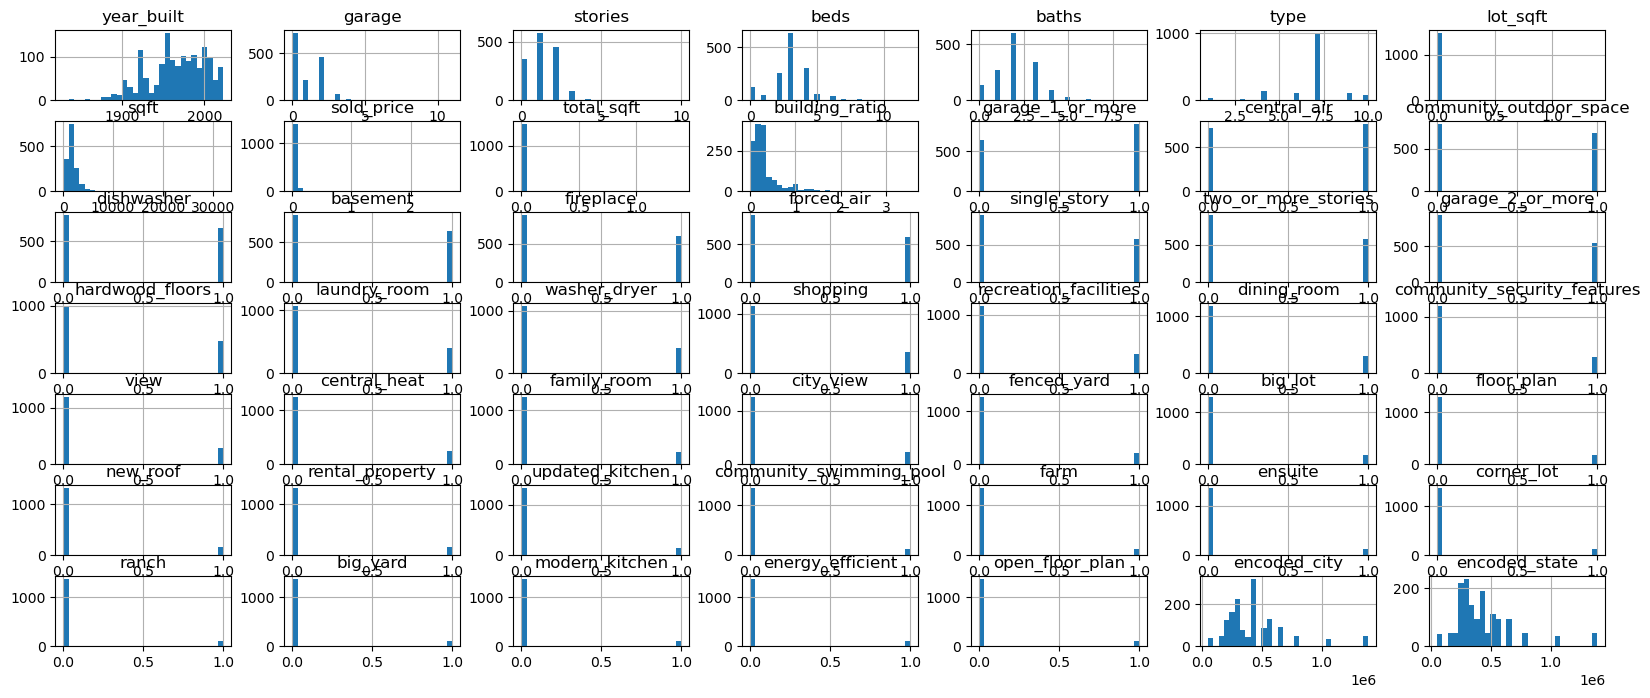

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram to check distributions
listings_df.hist(figsize=(20, 8), bins=30)
plt.show()

<Axes: ylabel='year_built'>

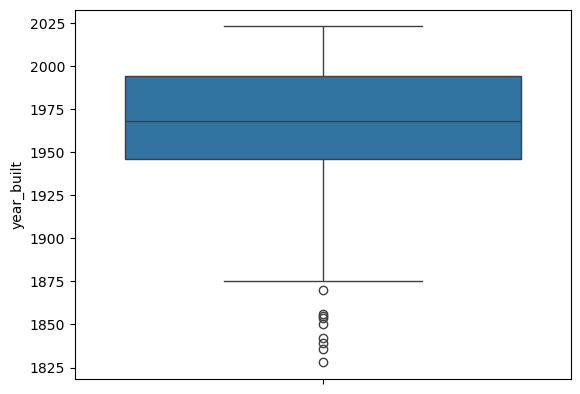

In [87]:
# Detecting and removing outliers 

# year_built
sns.boxplot(listings_df['year_built'])

In [88]:
# Dropping listings before 1880

listings_df = listings_df[listings_df['year_built'] > 1880]

<Axes: xlabel='year_built', ylabel='Count'>

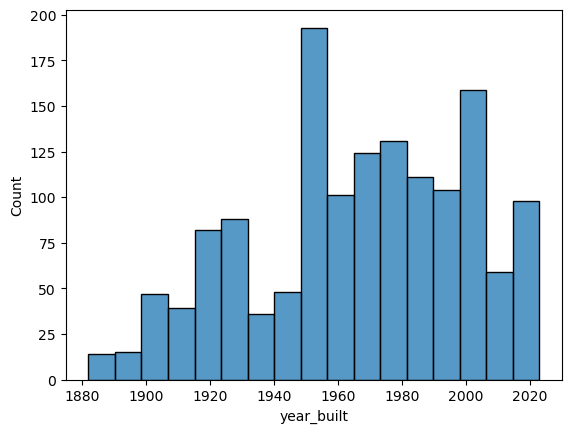

In [89]:
sns.histplot(listings_df['year_built'])

<Axes: xlabel='sqft', ylabel='sold_price'>

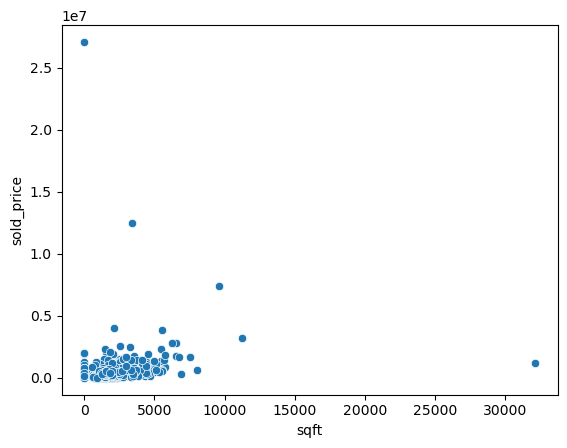

In [90]:
# Sqft 

sns.scatterplot(x=listings_df['sqft'], y=listings_df['sold_price'])

<Axes: ylabel='sqft'>

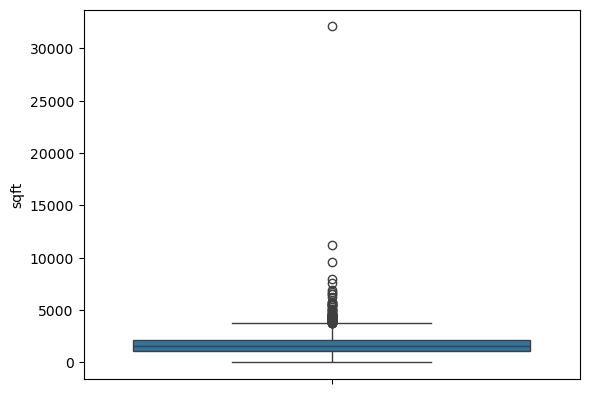

In [91]:
sns.boxplot(listings_df['sqft'])

In [92]:
listings_df = listings_df[listings_df['sqft'] < 8000]

<Axes: xlabel='sqft', ylabel='sold_price'>

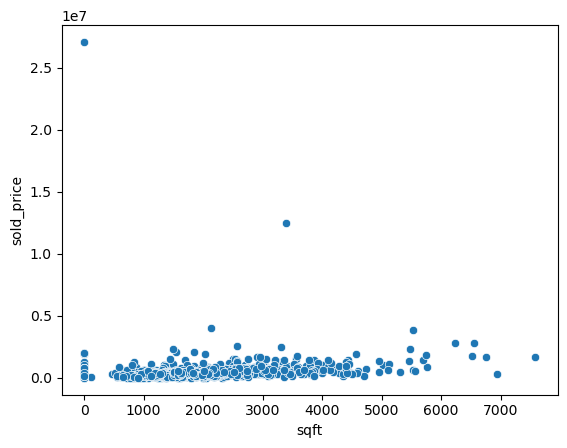

In [93]:
# sold_price 

sns.scatterplot(x=listings_df['sqft'], y=listings_df['sold_price'])

In [94]:
listings_df = listings_df[listings_df['sold_price'] < 3500000]

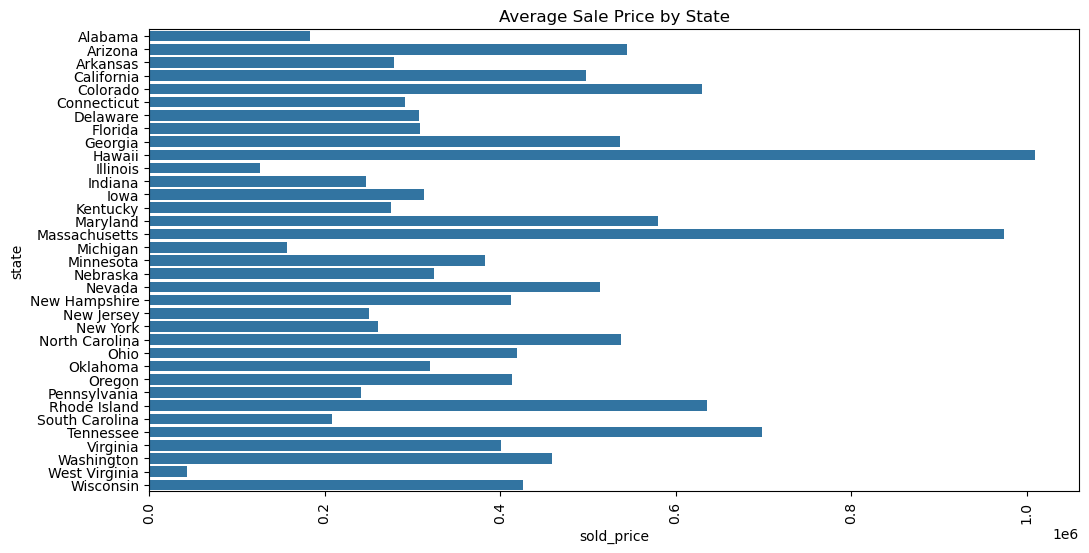

In [95]:
state_avg_price = listings_df.groupby("state")["sold_price"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x="sold_price", y="state", data=state_avg_price)
plt.xticks(rotation=90)
plt.title("Average Sale Price by State")
plt.show()

Scatterplots to show relationship between numerical variables and target

<function matplotlib.pyplot.show(close=None, block=None)>

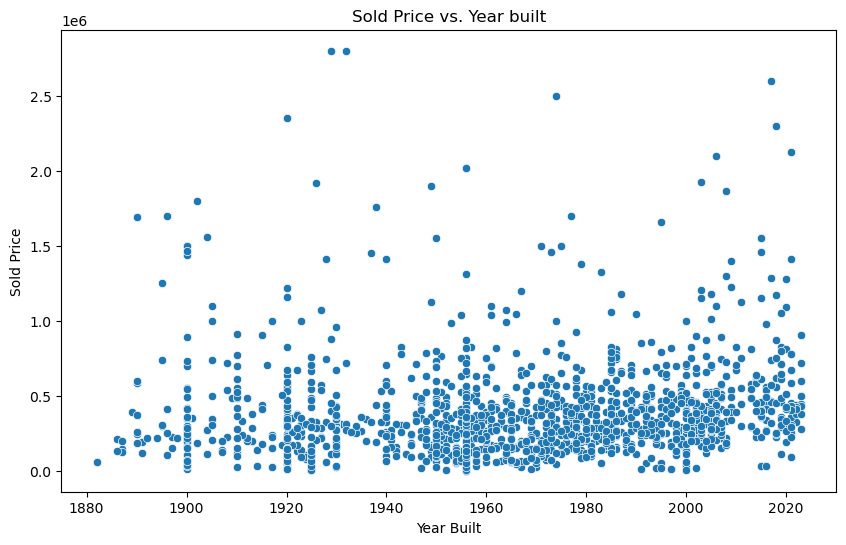

In [96]:
# Year Built
plt.figure(figsize=(10, 6))
sns.scatterplot(x=listings_df["year_built"], y=listings_df["sold_price"])
plt.xlabel("Year Built")
plt.ylabel("Sold Price")
plt.title("Sold Price vs. Year built")
plt.show

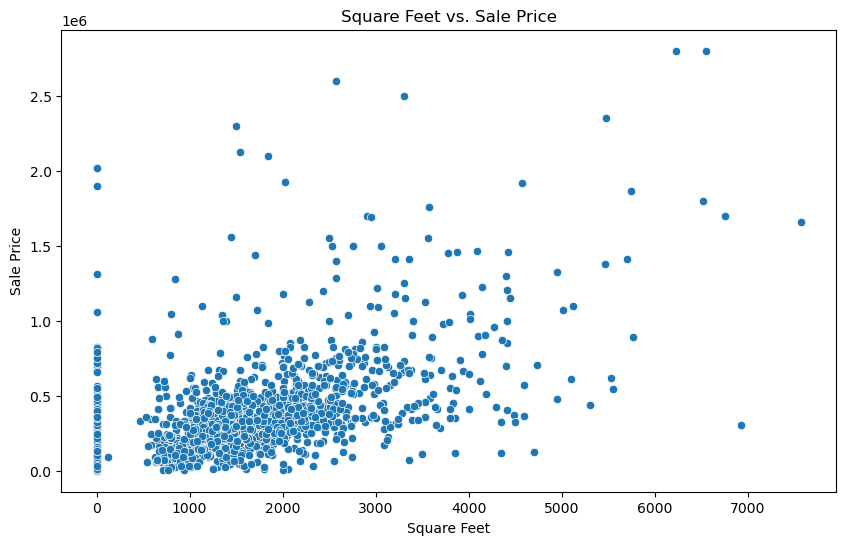

In [97]:
# Sqft
plt.figure(figsize=(10, 6))
sns.scatterplot(x=listings_df["sqft"], y=listings_df["sold_price"])
plt.xlabel("Square Feet")
plt.ylabel("Sale Price")
plt.title("Square Feet vs. Sale Price")
plt.show()

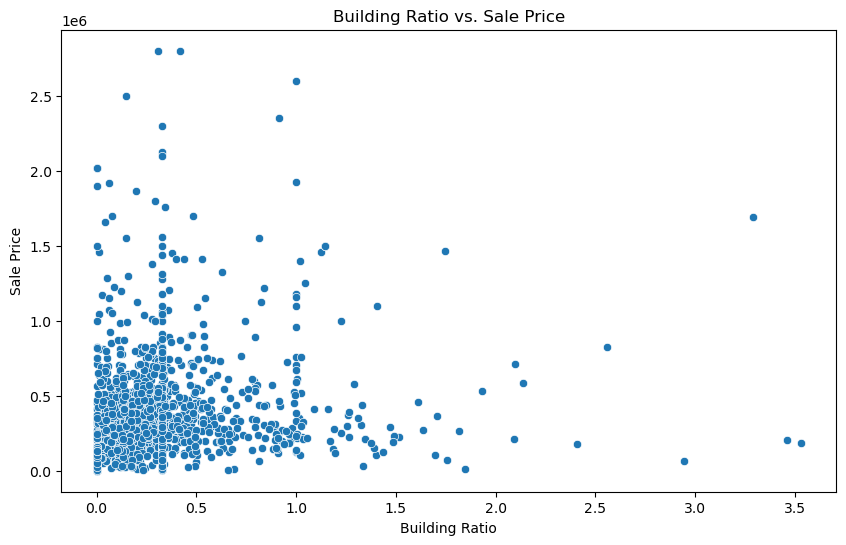

In [98]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=listings_df["building_ratio"], y=listings_df["sold_price"])
plt.xlabel("Building Ratio")
plt.ylabel("Sale Price")
plt.title("Building Ratio vs. Sale Price")
plt.show()

<Axes: xlabel='encoded_state', ylabel='sold_price'>

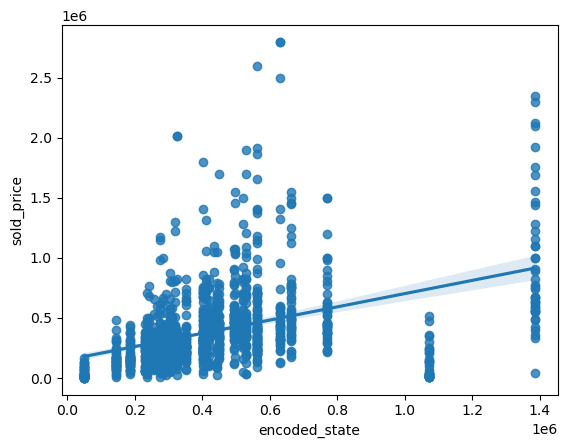

In [99]:
sns.regplot(x=listings_df["encoded_state"], y=listings_df["sold_price"])

<Axes: >

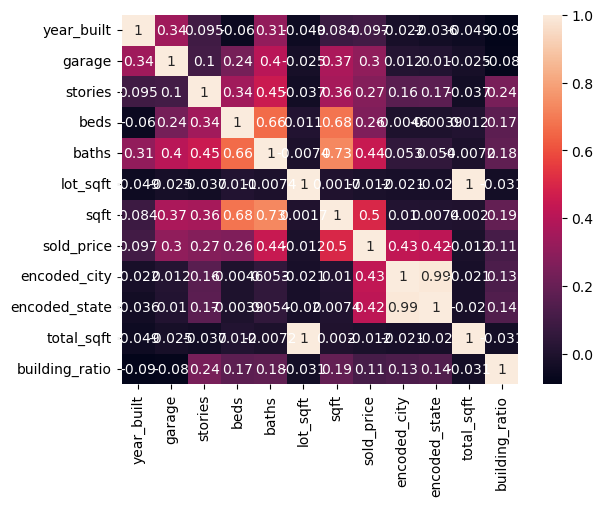

In [100]:
sns.heatmap(listings_df[['year_built', 'garage', 'stories', 'beds', 'baths', 'lot_sqft', 'sqft', 'sold_price', 'encoded_city', 'encoded_state', 'total_sqft', 'building_ratio']].corr(numeric_only=True), annot=True)

## Scaling and Finishing Up

Now is a great time to scale the data and save it once it's preprocessed.
- You can save it in your data folder, but you may want to make a new `processed/` subfolder to keep it organized

In [101]:
from sklearn.preprocessing import StandardScaler

# Choose scaling method
scaler = StandardScaler()

# Select numeric columns for scaling
cols_to_scale = ['lot_sqft', 'sqft', 'total_sqft', 'building_ratio', 'encoded_city', 'encoded_state']
listings_df.loc[:, cols_to_scale] = scaler.fit_transform(listings_df[cols_to_scale])

In [102]:
# Define file path for processed data 
processed_dir = os.path.join(main_dir, 'processed_data')
os.makedirs(processed_dir, exist_ok=True)

# Save the processed dataset
processed_listings = listings_df.drop(columns=['city', 'state', 'property_id'])
processed_listings.to_csv(os.path.join(processed_dir, 'processed_real_estate_listings.csv'), index=False)
print("Processed dataset saved successfully!")

# Example train/test split on processed dataset and save to csv
X = processed_listings.drop(columns='sold_price')
y = processed_listings['sold_price']

kf = KFold(n_splits=5, shuffle=True, random_state=13)

for train_idx, test_idx in kf.split(X):
    example_train_df = processed_listings.iloc[train_idx].copy()
    example_test_df = processed_listings.iloc[test_idx].copy()

example_train_df.to_csv(os.path.join(processed_dir, 'example_train_data.csv'), index=False)
example_test_df.to_csv(os.path.join(processed_dir, 'example_test_data.csv'), index=False)
print("Example train/test datasets saved successfully!")

Processed dataset saved successfully!
Example train/test datasets saved successfully!
